# Customer Segmentation for E-commerce

#### Import the required libraries

In [27]:
import pandas as pd
from datetime import datetime
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [29]:
# create a dataframe
df = pd.read_csv("/Users/ricki/Documents/Freelance/Projects/CustomerSegmentation/RFM-Segmentation/data/Online Retail.csv", encoding='ISO-8859-1')
#print(df.head())
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Dataset credits:
Chen, D. (2015). Online Retail [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5BW33.

### Inspect the Data:

In [30]:
# Check for missing values and data types.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


#### Basic Summary Statistics:

In [31]:
display(HTML("Basic Summary Statistics" + df.describe().to_html()))

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [32]:
# Value counts for categorical columns
print(df.value_counts())

InvoiceNo  StockCode  Description                          Quantity  InvoiceDate       UnitPrice  CustomerID  Country       
555524     22698      PINK REGENCY TEACUP AND SAUCER        1        6/5/2011 11:37    2.95       16923.0     United Kingdom    20
           22697      GREEN REGENCY TEACUP AND SAUCER       1        6/5/2011 11:37    2.95       16923.0     United Kingdom    12
572861     22775      PURPLE DRAWERKNOB ACRYLIC EDWARDIAN   12       10/26/2011 12:46  1.25       14102.0     United Kingdom     8
572344     M          Manual                                48       10/24/2011 10:43  1.50       14607.0     United Kingdom     6
578289     23395      BELLE JARDINIERE CUSHION COVER        1        11/23/2011 14:07  3.75       17841.0     United Kingdom     6
                                                                                                                                ..
553915     21174      POTTERING IN THE SHED METAL SIGN      12       5/19/2011 19:51   2.

In [33]:
print(df['Country'].value_counts().head(5)) # Top 5 countries

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64


In [34]:
print(df['Description'].value_counts().head(5)) # Top 5 products

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64


### Data Preprocessing


In [35]:
# Check columns with missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [36]:
# Handle Missing Values

df['Description'] = df['Description'].fillna('Unknown') # Fill missing values for Description
df = df.dropna() # Drop missing values

In [37]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [38]:
# Check for negative numbers in quantity and unit price
print("Negative Quantity:", df[df['Quantity'] < 0].shape[0])
print("Negative Unit Price:", df[df['UnitPrice'] < 0].shape[0])

Negative Quantity: 8905
Negative Unit Price: 0


In [39]:
# Convert Quantity to absolute values
df['Quantity'] = df['Quantity'].abs()

In [40]:
# Check for duplicates
duplicates = df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 5225


In [41]:
df = df.drop_duplicates()

#### Feature Engineering

In [42]:
# Create features for clustering:
# Recency: Days since last purchase
# Frequency: Total number of purchases
# Monetary: Total purchase value

current_date = datetime.now()
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (current_date - x.max()).days,
    "CustomerID": "count",
    "UnitPrice": "sum"
}).rename(columns={
    "InvoiceDate": "Recency",
    "CustomerID": "Frequency",
    "UnitPrice": "Monetary"
})
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0        5123          2      2.08
12347.0        4799        182    481.21
12348.0        4873         31    178.71
12349.0        4816         73    605.10
12350.0        5107         17     65.30


#### Normalize Data

In [43]:
# Scale the features to a uniform range
scaler = StandardScaler() 
rfm_scaled = scaler.fit_transform(rfm) 

#### Apply K-Means Clustering Algorithm 
K-Means is a popular clustering algorithm that groups similar data points into clusters

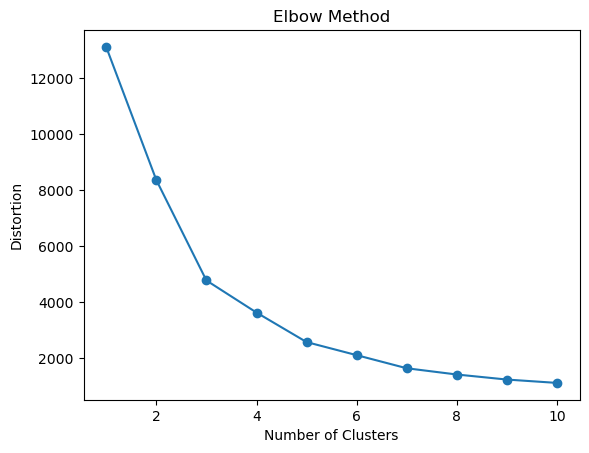

In [44]:
distortions = [] # Initialize an empty list to store the distortion values
tolerance = 0.01   # Set a tolerance value to stop the loop
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42) # Initialize the KMeans model
    kmeans.fit(rfm_scaled)
    inertia = kmeans.inertia_ 
    if k > 1 and abs(distortions[-1] - inertia) < tolerance: # Check if the difference is less than the tolerance
        break 
    distortions.append(inertia) 
plt.plot(range(1, 11), distortions, marker='o') 
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()
plt.show()

#### Fit the Model

In [45]:
# Fit the Model:
# Choose the optimal number of clusters and fit the model.

kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)
print(rfm.head())

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0        5123          2      2.08        2
12347.0        4799        182    481.21        0
12348.0        4873         31    178.71        0
12349.0        4816         73    605.10        0
12350.0        5107         17     65.30        2


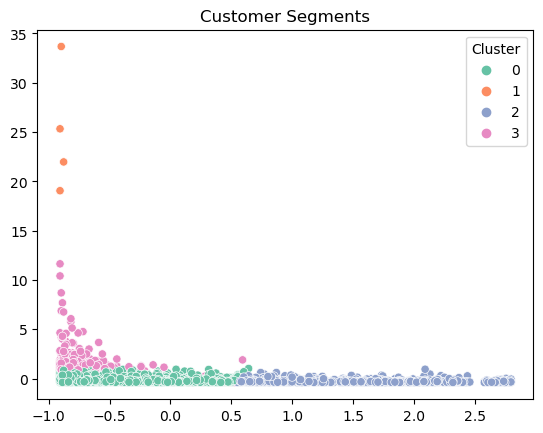

In [46]:
# Visualize the Clusters

sns.scatterplot(
    x=rfm_scaled[:, 0], y=rfm_scaled[:, 1],
    hue=rfm["Cluster"], palette="Set2"
)
plt.title("Customer Segments")
plt.show()

In [47]:
# Cluster Profiles
cluster_summary = rfm.groupby("Cluster").mean() # Calculate mean RFM values for each cluster.
print(cluster_summary)

             Recency    Frequency      Monetary
Cluster                                        
0        4840.694133    71.363546    220.679526
1        4837.142857  3400.142857  28077.950000
2        5047.449343    27.336773     98.552487
3        4812.109434   498.660377   1600.202151


In [ ]:
# Clusters based on their behavior

Cluster 0: Occasional low buyers
Cluster 1: High-value frequent buyers
Cluster 2: Minimal spenders
Cluster 3: Frequent moderate buyers

In [49]:
def marketing_plan(cluster_summary):
    '''
    Simple function that prints a marketing plan based on the cluster summary data
    '''
    for cluster, summary in cluster_summary.iterrows():
        if cluster == 0: 
            print("Cluster 0: Occasional low buyers")
            print("Strategy: Send personalized offers and discounts")
            print("Engagement Campaigns: Email marketing and social media campaigns")
            print("Loyalty Programs: Introduce loyalty programs")
            print("Product Recommendations: Provide personalized product recommendations")
        
        elif cluster == 1: 
            print("Cluster 1: High-value frequent buyers")
            print("Strategy: Offer exclusive rewards and VIP programs")
            print("Feedback: Regularly seek feedback")
            print("Upselling and Cross-Selling: Increase average order value")
        
        elif cluster == 2:  
            print("Cluster 2: Minimal spenders")
            print("Strategy: Use re-engagement campaigns")
            print("Educational Content: Provide educational content")
            print("Simplify Purchase Process: Ensure a user-friendly purchase process")
            print("Win-Back Strategies: Implement personalized emails or special offers")
        
        elif cluster == 3: 
            print("Cluster 3: Frequent moderate buyers")
            print("Strategy: Introduce subscription services")
            print("Cross-Selling: Recommend complementary products")
            print("Exclusive Previews: Offer exclusive previews of new products")
            print("Loyalty Programs: Enhance loyalty programs")
        
        print("\n")

cluster_summary = pd.DataFrame({
    'Recency': [4840.69, 4837.14, 5047.45, 4812.11],
    'Frequency': [71.36, 3400.14, 27.34, 498.66],
    'Monetary': [220.68, 28077.95, 98.55, 1600.20]
}, index=[0, 1, 2, 3])

marketing_plan(cluster_summary)

Cluster 0: Occasional low buyers
Strategy: Send personalized offers and discounts
Engagement Campaigns: Email marketing and social media campaigns
Loyalty Programs: Introduce loyalty programs
Product Recommendations: Provide personalized product recommendations


Cluster 1: High-value frequent buyers
Strategy: Offer exclusive rewards and VIP programs
Feedback: Regularly seek feedback
Upselling and Cross-Selling: Increase average order value


Cluster 2: Minimal spenders
Strategy: Use re-engagement campaigns
Educational Content: Provide educational content
Simplify Purchase Process: Ensure a user-friendly purchase process
Win-Back Strategies: Implement personalized emails or special offers


Cluster 3: Frequent moderate buyers
Strategy: Introduce subscription services
Cross-Selling: Recommend complementary products
Exclusive Previews: Offer exclusive previews of new products
Loyalty Programs: Enhance loyalty programs


